# ANALYSIS OF UNSERVED QUOTE DEMAND

In this notebook we study the demand of Justos service in terms of quotes. This is analyzed in the CEP code and municipality level and studied for those quotes associated with a CEP code Justos currently does not cover.

**Most updated map with all the generated data is available at: https://drive.google.com/drive/folders/1h-s7cij7WyFWgAcIwULc2AOyVN8pHidg**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import psycopg2, os, geopandas

from shapely import wkt
from shapely.geometry import MultiPolygon, Polygon

# Establish connection and create its cursor
try: 
    conn = psycopg2.connect(f"host={os.environ['AURORA_POSTGRES_HOST']} dbname={os.environ['AURORA_POSTGRES_DATABASE']} user={os.environ['AURORA_POSTGRES_USERNAME']} password={os.environ['AURORA_POSTGRES_PWD']}")
    cur = conn.cursor()
except psycopg2.Error as e: 
    print("Error: Could not make connection to the Postgres database")
    print(e)
    

---
## 1. Quote collection and data curation

Collect the quotes

In [2]:
# Collect quotes
cur.execute("SELECT * FROM log_registry.quoting_logs")
raw_quoting_logs = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
display(raw_quoting_logs.shape)

# Drop duplicates by quote_id
raw_quoting_logs = raw_quoting_logs.drop_duplicates(subset=['quote_id'])
display(raw_quoting_logs.shape)

raw_quoting_logs.head(2)

(5399, 11)

(5019, 11)

,id,quote_id,request_date,response_status_code,request_url,request_body,response_body,models_metadata,bounds_version_id,raw_prices,inputs_and_predicts
0,12,1216126c-aef7-41b0-ab51-0c2f9a02ce76,2021-05-11 16:04:41,422,https://hrlofvr97f.execute-api.us-east-1.amazo...,"{'user': {'id': 15, 'cep': '46000-000', 'cpf':...","{'error': [{'loc': ['body', 'exposure', 'brand...",None,None,None,None
2,14,075418cc-ff3a-4276-ae00-c9a26a1217e7,2021-05-11 21:31:09,200,https://hrlofvr97f.execute-api.us-east-1.amazo...,"{'user': {'id': 13, 'cep': '51534-586', 'cpf':...","{'perils': {'app': 0.33, 'rcf': 18.41, 'fire':...",None,None,None,None


Normalize request body json

In [3]:
quoting_logs = pd.json_normalize(raw_quoting_logs.request_body.tolist())
for col in ['id', 'request_date']:
    quoting_logs[col] = raw_quoting_logs[col]

quoting_logs.head(2)


,quote,user.id,user.cep,user.cpf,user.name,user.idwall.cpf.pep,user.idwall.cpf.nome,user.idwall.cpf.sexo,user.idwall.cpf.fonte,user.idwall.cpf.renda,...,exposure.report.AnoExercicioLicenciamento,exposure.report.DataInclusaoIntencaoGravame,exposure.report.NomeFinanciadoIntencaoGravame,exposure.report.DataInclusaoIntencaoTrocaFinanc,exposure.report.CpfCnpjFinanciadoIntencaoGravame,exposure.report.RestricaoFinanceiraIntencaoGravame,exposure.report.NomeAgenteFinanceiroIntencaoGravame,exposure.insurer_name,id,request_date
0,1216126c-aef7-41b0-ab51-0c2f9a02ce76,15,46000-000,396.092.038-50,name,False,FELIPHE MARTINS SANTORO,M,RECEITA FEDERAL,3 - 4 A 10 SM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,2021-05-11 16:04:41
1,075418cc-ff3a-4276-ae00-c9a26a1217e7,13,51534-586,022.021.770-00,Jorge,True,EVERSON FLORES DA SILVA,M,RECEITA FEDERAL,1 - ATE 2 SM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


Keep the columns relevant to our analysis

In [4]:
# Columns to keep
columns_of_interest = {
    'quote': 'quote',
    'user.id': 'user_id',
    'user.cep': 'cep',
    'user.idwall.cpf.sexo': 'gender',
    'user.idwall.cpf.data_de_nascimento': 'date_of_birth',
    'exposure.report.PrecoFipe': 'fipe_price',
    'insurance.bonus_score': 'bonus_score',
    'request_date': 'request_date'

}


# For data exploration
"""
start = 65
finish = start+10

display(quoting_logs.columns[start:finish])

display(quoting_logs[quoting_logs.columns[start:finish]])
"""

# Curate the data
quoting_logs = quoting_logs[columns_of_interest.keys()].rename(columns=columns_of_interest)
quoting_logs.head()


,quote,user_id,cep,gender,date_of_birth,fipe_price,bonus_score,request_date
0,1216126c-aef7-41b0-ab51-0c2f9a02ce76,15,46000-000,M,30/07/1989,NaN,NaN,2021-05-11 16:04:41
1,075418cc-ff3a-4276-ae00-c9a26a1217e7,13,51534-586,M,03/04/1988,NaN,NaN,NaT
2,8c6889e3-becc-4219-a1ab-399f6a1d25d5,6,98765-432,M,28/08/1989,NaN,NaN,2021-05-11 21:31:09
3,c443f1fd-5611-45aa-b857-e2d905689b48,63,04623-070,M,30/07/1989,NaN,NaN,2021-05-11 21:34:03
4,6d9ca2be-f222-4def-be60-f7c16a5ea654,66,12345-678,M,28/08/1989,NaN,NaN,NaT


Drop records with no CEP, fipe price or request date

In [5]:
display(quoting_logs.isna().sum())
quoting_logs.dropna(subset=['cep', 'gender', 'fipe_price', 'request_date'], inplace=True)
display(quoting_logs.isna().sum())


quote               0
user_id             0
cep                 4
gender              1
date_of_birth       0
fipe_price         65
bonus_score      3247
request_date      374
dtype: int64

quote               0
user_id             0
cep                 0
gender              0
date_of_birth       0
fipe_price          0
bonus_score      2907
request_date        0
dtype: int64

Clean CEP codes to unify format and drop CEP codes that make no sense or that are not in Sao Paulo

In [6]:
quoting_logs['cep'] = quoting_logs.cep.apply(lambda x: x.replace('-', ''))
print('Total records in logs:', quoting_logs.shape[0])

# Drop records with CEP codes that dont have 8 digits
display(quoting_logs['cep'].str.len().value_counts())
quoting_logs = quoting_logs[quoting_logs['cep'].str.len()==8]
print('Total records in logs:', quoting_logs.shape[0])

# Drop records with CEP code that are not in Sao Paulo
quoting_logs = quoting_logs[(quoting_logs['cep'].str.startswith('0')) |
                            (quoting_logs['cep'].str.startswith('1'))]

print('Total records in logs:', quoting_logs.shape[0])


Total records in logs: 4590


8     4580
9        8
11       1
19       1
Name: cep, dtype: int64

Total records in logs: 4580
Total records in logs: 3935


Transformations and selection of final columns

In [7]:
# Date of birth to age in years
from datetime import datetime
quoting_logs['age_years'] = quoting_logs.copy().date_of_birth.apply(lambda x: datetime.now().year - datetime.strptime(x, '%d/%m/%Y').year)
quoting_logs.drop(columns='date_of_birth', inplace=True)

# Request date to age of request in month
from dateutil import relativedelta
quoting_logs['request_age_months'] = quoting_logs.copy().request_date.apply(lambda x: relativedelta.relativedelta(datetime.now(), x))
quoting_logs['request_age_months'] = quoting_logs['request_age_months'].apply(lambda x: x.months + (12*x.years))

# Fipe price to float
quoting_logs['fipe_price'] = quoting_logs['fipe_price'].astype(str).apply(lambda x: x.replace('.','').replace(',','.')).astype(float)

# Filter columns
quoting_logs = quoting_logs[['quote', 'user_id', 'request_age_months',
                             'gender', 'age_years', 'cep', 'fipe_price', 'bonus_score']]
quoting_logs


,quote,user_id,request_age_months,gender,age_years,cep,fipe_price,bonus_score
55,13-286-1627717201624,13,8,M,33,08131000,27327.0,NaN
68,13-283-1627045492871,13,5,M,33,01311000,55703.0,NaN
69,13-283-1627307745881,13,8,M,33,01311000,55703.0,NaN
70,7-283-1627307931862,7,8,M,33,01405100,55703.0,NaN
71,13-283-1627311394276,13,8,M,33,01311000,55703.0,NaN
...,...,...,...,...,...,...,...,...
5014,6260f7a5-f7db-4ad4-8ce9-034669f3c081,19963,0,M,39,04843310,26151.0,1.0
5015,553f7430-00e9-49b9-8ccd-d6e878395461,19965,0,M,33,08780810,40215.0,99.0
5016,ea0fb3ff-fc90-416a-afe0-307a687d11b2,197,0,M,38,04545042,38722.0,99.0
5017,1c20dcde-3add-49b4-afcd-8479e5515f01,19967,0,M,33,06060110,39172.0,99.0


---

**SUMMARY**: From 5388 quotes, we end up with 3924 usable quotes after:
- Removing duplicate user quotes (5388 -> 5008)
- Removing quotes with missing relevant info including CEP and request date (5008 -> 4579)
- Removing quotes with invalid CEP formats - not 8 digits after field cleanup (4579 -> 3924)

---

## 2. Extra info for quotes and filter

### 2.1. Info on open CEPs

Collect open CEPs data

In [8]:
# Collect table
cur.execute("SELECT * FROM dbt_albertoscf.covered_ceps")
dt = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
dt = dt[['cep', 'reg_susep', 'is_open', 'timestamp_changed']].copy().fillna(0)
dt['is_open'] = dt['is_open'].astype(bool)

# Pick last updated record for each CEP
dt = dt.sort_values('timestamp_changed').groupby('cep').last().drop([0]).reset_index().drop(columns=['timestamp_changed'])

# Convert numeric CEP to string
def cep_to_str(number):
    return ("0"*(8-len(str(number)))+str(number))
dt['cep'] = dt['cep'].apply(lambda x: cep_to_str(x))

dt.head()


,cep,reg_susep,is_open
0,00000001,0.0,False
1,00000007,0.0,False
2,00000011,0.0,False
3,00000012,0.0,False
4,00000036,0.0,False


Merge to the data

In [9]:
quoting_logs = quoting_logs.merge(dt, on='cep', how='left')
quoting_logs.head()


,quote,user_id,request_age_months,gender,age_years,cep,fipe_price,bonus_score,reg_susep,is_open
0,13-286-1627717201624,13,8,M,33,08131000,27327.0,NaN,NaN,NaN
1,13-283-1627045492871,13,5,M,33,01311000,55703.0,NaN,11.0,False
2,13-283-1627307745881,13,8,M,33,01311000,55703.0,NaN,11.0,False
3,7-283-1627307931862,7,8,M,33,01405100,55703.0,NaN,11.0,True
4,13-283-1627311394276,13,8,M,33,01311000,55703.0,NaN,11.0,False


Filter out CEPs that we do not have in the DB - **THIS SHOULD BE FURTHER INVESTIGATED, THESE CEP CODES ARE NEITHER IN CORREIOS DATA OR IN SUSE GEO_INFO SO HOW CAN WE FILL THEM UP?!**

In [10]:
# Collect all CEP codes for which we have info
cur.execute("""SELECT "CEP", code_tract FROM susep.geo_info_enhanced""")
geo_info = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
geo_info_ceps = set(geo_info.CEP)
len(geo_info_ceps)

# Drop records with CEPs we have no info on
print('Total records in logs:', quoting_logs.shape[0])
quoting_logs = quoting_logs[quoting_logs['cep'].isin(geo_info_ceps)]
print('Total records in logs:', quoting_logs.shape[0])


Total records in logs: 3935
Total records in logs: 3790


Finally drop records where CEP code is not in Sao Paulo UF as per assigned census tract, these are all with the `is_open` flag missing - **THESE CASES ARE INTERESTING TO STUDY SINCE THEY ACTUALLY SEEM TO BE IN SAO PAULO**

In [11]:
print('Total records in logs:', quoting_logs.shape[0])
quoting_logs = quoting_logs[quoting_logs['is_open'].notna()]
print('Total records in logs:', quoting_logs.shape[0])


Total records in logs: 3790
Total records in logs: 3742


Check the final data is good to work with

In [12]:
display(quoting_logs.isna().sum())
quoting_logs.head()


quote                    0
user_id                  0
request_age_months       0
gender                   0
age_years                0
cep                      0
fipe_price               0
bonus_score           2410
reg_susep                0
is_open                  0
dtype: int64

,quote,user_id,request_age_months,gender,age_years,cep,fipe_price,bonus_score,reg_susep,is_open
1,13-283-1627045492871,13,5,M,33,01311000,55703.0,NaN,11.0,False
2,13-283-1627307745881,13,8,M,33,01311000,55703.0,NaN,11.0,False
3,7-283-1627307931862,7,8,M,33,01405100,55703.0,NaN,11.0,True
4,13-283-1627311394276,13,8,M,33,01311000,55703.0,NaN,11.0,False
5,27-192-1626904006276,27,8,M,33,01131000,54689.0,NaN,11.0,True


---

### 2.2. Add the municipio code to the CEP in the quoting logs

We can add the municipio by curating the census tract, picking the first 7 digits

In [13]:
# Add the info on census_tract
quoting_logs = quoting_logs.merge(geo_info.rename(columns={'CEP': 'cep'}), on='cep', how='left')

# Create the UF and municipio code fields
quoting_logs['cod_uf'] = quoting_logs.code_tract.str[:2]
quoting_logs['cod_munic'] = quoting_logs.code_tract.str[2:7]
quoting_logs = quoting_logs.drop(columns=['code_tract'])

quoting_logs.head()


,quote,user_id,request_age_months,gender,age_years,cep,fipe_price,bonus_score,reg_susep,is_open,cod_uf,cod_munic
0,13-283-1627045492871,13,5,M,33,01311000,55703.0,NaN,11.0,False,35,50308
1,13-283-1627307745881,13,8,M,33,01311000,55703.0,NaN,11.0,False,35,50308
2,7-283-1627307931862,7,8,M,33,01405100,55703.0,NaN,11.0,True,35,50308
3,13-283-1627311394276,13,8,M,33,01311000,55703.0,NaN,11.0,False,35,50308
4,27-192-1626904006276,27,8,M,33,01131000,54689.0,NaN,11.0,True,35,50308


In [14]:
display(quoting_logs.cod_uf.unique())
display(quoting_logs.cod_munic.nunique())

array(['35'], dtype=object)

105



---
### 2.3. Add the municipio data

In [15]:
# Collect population data by municipio in Sao Paulo
cur.execute("""SELECT * FROM ibge.municipios WHERE cod_uf='35'""")
population_data_sp = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])

# Append it by cod_munic
quoting_logs = quoting_logs.merge(population_data_sp[['cod_munic', 'nome_do_municipio', 
                                                      'populacao_estimada_2021', 'estimated_population_density',
                                                      'municipio_geom_text']],
                                  on='cod_munic', how='left')
display(quoting_logs.shape)
quoting_logs.head()


(3742, 16)

,quote,user_id,request_age_months,gender,age_years,cep,fipe_price,bonus_score,reg_susep,is_open,cod_uf,cod_munic,nome_do_municipio,populacao_estimada_2021,estimated_population_density,municipio_geom_text
0,13-283-1627045492871,13,5,M,33,01311000,55703.0,NaN,11.0,False,35,50308,São Paulo,12396372,8149.556573817805,"POLYGON((-46.546244 -23.357909999, -46.545853 ..."
1,13-283-1627307745881,13,8,M,33,01311000,55703.0,NaN,11.0,False,35,50308,São Paulo,12396372,8149.556573817805,"POLYGON((-46.546244 -23.357909999, -46.545853 ..."
2,7-283-1627307931862,7,8,M,33,01405100,55703.0,NaN,11.0,True,35,50308,São Paulo,12396372,8149.556573817805,"POLYGON((-46.546244 -23.357909999, -46.545853 ..."
3,13-283-1627311394276,13,8,M,33,01311000,55703.0,NaN,11.0,False,35,50308,São Paulo,12396372,8149.556573817805,"POLYGON((-46.546244 -23.357909999, -46.545853 ..."
4,27-192-1626904006276,27,8,M,33,01131000,54689.0,NaN,11.0,True,35,50308,São Paulo,12396372,8149.556573817805,"POLYGON((-46.546244 -23.357909999, -46.545853 ..."


---

**SUMMARY**: From 3924 clean quotes, we end up with 3731 usable quotes after:
- Removing quotes with CEP codes we have no info for (3924 -> 3779)*
- Removing quotes with CEP not in Sao Paulo as per census_tract assignment (3779 -> 3731)

---

### 2.4. Append coordinates

Append CEP coordinates and location for future visualization

In [16]:
# Append lat lon info
cur.execute("""SELECT "CEP" as cep, lon as cep_lon, lat as cep_lat, imputation_method as cep_imputation_method FROM susep.geo_info_enhanced""")
geo_info = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
quoting_logs = quoting_logs.merge(geo_info, on='cep', how='left')

# Add location
quoting_logs['cep_location'] = quoting_logs.apply(lambda row: 'POINT('+str(row['cep_lon'])+' '+str(row['cep_lat'])+')', axis=1)


---
## 4. Analysis

### 4.1. Non-covered quotes

First filter those quotes belonging to CEPs we don't currently cover

In [17]:
display(quoting_logs.is_open.value_counts())
non_covered_quotes = quoting_logs[quoting_logs['is_open']==False].copy()

True     3070
False     672
Name: is_open, dtype: int64

#### BY CEP

In [24]:
cep_summary = non_covered_quotes.groupby('cep').agg({'quote': lambda x: len(x),
                                                     'nome_do_municipio': lambda x: x.iloc[0],
                                                     'request_age_months': lambda x: x.mean(),
                                                     'gender': lambda x: x.value_counts().sort_index()[0]/len(x),
                                                     'age_years': lambda x: x.mean(),
                                                     'fipe_price': lambda x: x.astype(float).mean(),
                                                     'cep_location': lambda x: x.iloc[0]}).reset_index().rename(columns={'quote': 'total_noncovered_quotes',
                                                                                                                         'nome_do_municipio': 'nome_do_municipio', 
                                                                                                                         'request_age_months': 'mean_request_age_months',
                                                                                                                         'gender': 'fraction_females_quoters',
                                                                                                                         'age_years': 'mean_quoter_age_years',
                                                                                                                         'fipe_price': 'mean_fipe_price',
                                                                                                                         'cep_location': 'cep_location'})
cep_summary.head()
                    

,cep,total_noncovered_quotes,nome_do_municipio,mean_request_age_months,fraction_females_quoters,mean_quoter_age_years,mean_fipe_price,cep_location
0,01200000,2,São José dos Campos,3.000000,1.0,33.000000,36934.000000,POINT(-46.02273738316 -23.0189495839379)
1,01311000,6,São Paulo,6.500000,1.0,35.166667,45102.333333,POINT(-46.8563231018514 -23.2936846265326)
2,01325000,3,Itatiba,1.333333,1.0,34.000000,41733.333333,POINT(-46.7160512863304 -23.2873513277888)
3,01435000,1,São Paulo,3.000000,1.0,32.000000,12787.000000,POINT(-46.7722266829069 -23.2113928594065)
4,01500000,1,São José do Rio Preto,3.000000,1.0,33.000000,17548.000000,POINT(-48.4128513116783 -21.8497306442817)


Create geodf and export

In [25]:
# create geomtry column from wkt
cep_summary['cep_location'] = cep_summary['cep_location'].apply(wkt.loads)

# Create geodf
cep_summary = geopandas.GeoDataFrame(cep_summary, geometry='cep_location', crs="EPSG:4326")

# Export
cep_summary.to_file("data/quotes_summary_by_cep.json", driver="GeoJSON")


#### BY MUNICIPALITY
See how these non-covered quotes are distributed by municipality

In [19]:
# Create a summary table
municipio_summary = non_covered_quotes.groupby('nome_do_municipio').agg({'quote': lambda x: len(x),
                                                                         'request_age_months': lambda x: x.mean(),
                                                                         'gender': lambda x: x.value_counts().sort_index()[0]/len(x),
                                                                         'age_years': lambda x: x.mean(),
                                                                         'fipe_price': lambda x: x.astype(float).mean(),
                                                                         'populacao_estimada_2021': lambda x: x.iloc[0],
                                                                         'municipio_geom_text': lambda x: x.iloc[0]}).reset_index().rename(columns={'quote': 'total_noncovered_quotes',
                                                                                                                                                    'request_age_months': 'mean_request_age_months',
                                                                                                                                                    'gender': 'fraction_females_quoters',
                                                                                                                                                    'age_years': 'mean_quoter_age_years',
                                                                                                                                                    'fipe_price': 'mean_fipe_price',
                                                                                                                                                    'municipio_geom_text': 'municipio_geom_text'})
# Add a column with density of non-supported quotes over population in the municipality
municipio_summary['density_of_noncovered_quotes'] = municipio_summary['total_noncovered_quotes']/municipio_summary['populacao_estimada_2021']
municipio_summary.head()


,nome_do_municipio,total_noncovered_quotes,mean_request_age_months,fraction_females_quoters,mean_quoter_age_years,mean_fipe_price,populacao_estimada_2021,municipio_geom_text,density_of_noncovered_quotes
0,Aparecida,1,0.0,1.0,22.0,27501.0,36211,"POLYGON((-45.211777572 -22.817563752, -45.2124...",0.000028
1,Araraquara,2,2.5,0.5,34.5,43765.0,240542,"POLYGON((-48.186744872 -21.618747988, -48.1843...",0.000008
2,Araras,2,3.5,0.5,36.5,20958.0,136739,"POLYGON((-47.23694227 -22.19487334, -47.235498...",0.000015
3,Araçariguama,1,1.0,1.0,49.0,26127.0,23343,"POLYGON((-47.041263679 -23.355088216, -47.0406...",0.000043
4,Assis,1,0.0,1.0,42.0,15072.0,105768,"POLYGON((-50.395839124 -22.447374743, -50.3936...",0.000009


In [27]:
non_covered_quotes[non_covered_quotes.cod_munic=='50308'].cep.value_counts()

01311000    6
04863320    3
04660000    2
08420000    2
04863015    2
           ..
04240000    1
04855515    1
04864010    1
04633000    1
04458000    1
Name: cep, Length: 65, dtype: int64

Analyze density of noncovered quotes by municipio

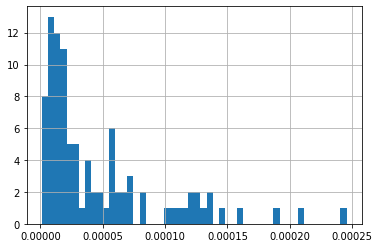

In [20]:
municipio_summary.density_of_noncovered_quotes.hist(bins=50)
plt.show()

Create geodf and export

In [21]:
# create geomtry column from wkt
municipio_summary['municipio_geom_text'] = municipio_summary['municipio_geom_text'].apply(wkt.loads)

# Create geodf
municipio_summary = geopandas.GeoDataFrame(municipio_summary, geometry='municipio_geom_text', crs="EPSG:4326")

# Export
municipio_summary.to_file("data/quotes_summary_by_municipio.json", driver="GeoJSON")


#### AUX: BODYSHOPS DATA GEOJSON

In [ ]:
cur.execute("SELECT * FROM staging_tables.stg_accredited_bodyshops")
bodyshops_info = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])

# Add coordinates
bodyshops_info['bodyshops_coords'] = bodyshops_info.apply(lambda row: 'POINT('+str(row['longitude'])+' '+str(row['latitude'])+')', axis=1).apply(wkt.loads)

# Filter columns and create geodf
bodyshops_info = geopandas.GeoDataFrame(bodyshops_info, geometry='bodyshops_coords', crs="EPSG:4326")[['nome_da_oficina', 'full_address', 'cep', 'bodyshops_coords']]
bodyshops_info.to_file("data/bodyshops_info.json", driver="GeoJSON")
